# Quantum Teleportation

Source: https://qiskit.org/textbook/ch-algorithms/teleportation.html

In [2]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble

from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state

In [8]:
#set up quantum circuit

qr = QuantumRegister(3, name='q')
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')

teleportation_circuit = QuantumCircuit(qr, crz, crx)

A third party creates an entangled pair of qubits, sends them to Alice and Bob. This is a Bell Pair

In [9]:
def create_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

In [10]:
create_bell_pair(teleportation_circuit, 1, 2)

teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Now Alice applies a CNOT and a Hadamard gate as follows:

In [11]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [12]:
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)

teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

Now Alice measures her qubits and stores the result in two classical bits, which she sends to Bob

In [13]:
def measure_and_send(qc, a, b):
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [14]:
measure_and_send(teleportation_circuit, 0, 1)

teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

Bob now applies a gate to his remaining qubit as follows:
- **00** do nothing
- **01** apply X gate
- **10** apply Z gate
- **11** apply ZX gate

Note the `.c_if()` function below is a control gate that uses a classical bit for control

In [15]:
def bob_gates(qc, qubit, crz, crx):
    
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

In [16]:
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)

teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ = 1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

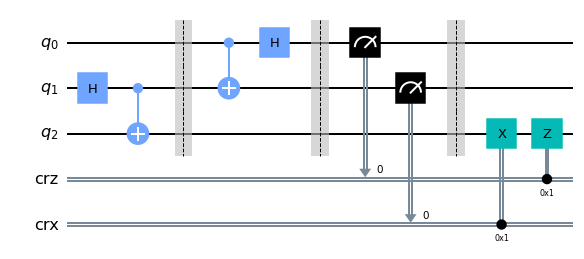

In [18]:
teleportation_circuit.draw('mpl')

### Simulating the teleportation protocol

<IPython.core.display.Latex object>

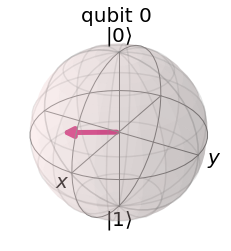

In [19]:
psi = random_state(1)

display(array_to_latex(psi, prefix='|\\psi\\rangle ='))
plot_bloch_multivector(psi)

In [20]:
init_gate = Initialize(psi)
init_gate.label = 'init'

#### Using the simulated statevector

In [25]:
qr = QuantumRegister(3, name = 'q')
crz = ClassicalRegister(1, name = 'crz')
crx = ClassicalRegister(1, name = 'crx')
qc = QuantumCircuit(qr, crz, crx)

In [26]:
#first initialize Alice's q0
qc. append(init_gate, [0])
qc.barrier()

#step 1 - begin teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

#step 2 - send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

#step 3 - Alice sends her classical bits to Bob
measure_and_send(qc, 0, 1)

#step 4 - Bob decodes qubits
bob_gates(qc, 2, crz, crx)

qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘ 
                                             ║  ║    ║   ┌──╨──┐
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞
                                             0  ║ ┌──╨──┐└─────┘
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════
                                                0 └─────┘

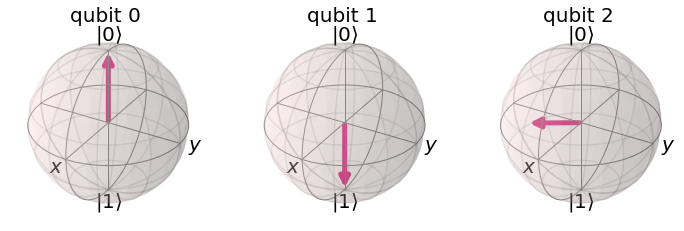

In [27]:
sim = Aer.get_backend('aer_simulator')

qc.save_statevector()

out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

Since quantum gates are reversible, find the inverse of the gates using

`inverse_init_gate = init_gate.gates_to_uncompute()`

In [28]:
inverse_init_gate = init_gate.gates_to_uncompute()

qc.append(inverse_init_gate, [2])
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                  ░ »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├──────────────────░─»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐               ░ »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────────────░─»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐  ░ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├──░─»
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘  ░ »
                                             ║  ║    ║   ┌──╨──┐   »
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞═══»
                                             0  ║ ┌──╨──┐└─────┘   »
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞══════════»
                                                0 └─────┘          »
«                       
«  q_0: ────────────────
«                       
«  q_1: ────────────────
«       ┌──────────────┐
«  q_2: ┤ disentangler ├
«       └──────────────┘
«crz: 1/════════════════
«                       
«crx: 1/════════════════
«

Now we add one more classical register to measure and store information

In [30]:
cr_result = ClassicalRegister(1)

qc.add_register(cr_result)
qc.measure(2,2)

qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                  ░ »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├──────────────────░─»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐               ░ »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────────────░─»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐  ░ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├──░─»
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘  ░ »
                                             ║  ║    ║   ┌──╨──┐   »
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞═══»
                                             0  ║ ┌──╨──┐└─────┘   »
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞══════════»
                                                0 └─────┘          »
 c1: 1/════════════════════════════════════════════════════════════»
                                                                   »
«                          
«  q_0: ───────────────────
«                          
«  q_1: ───────────────────
«       ┌──────────────┐┌─┐
«  q_2: ┤ disentangler ├┤M├
«       └──────────────┘└╥┘
«crz: 1/═════════════════╬═
«                        ║ 
«crx: 1/═════════════════╬═
«                        ║ 
« c1: 1/═════════════════╩═
«                        0

Simulation failed and returned the following error message:
ERROR: Failed to load qobj: Duplicate key "statevector" in save instruction.


ValueError: need at least one array to concatenate

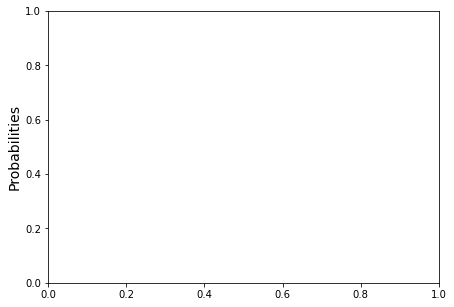

In [31]:
# now we run the experiment

t_qc = transpile(qc, sim)

t_qc.save_statevector()

counts = sim.run(t_qc).result().get_counts()

plot_histogram(counts)

Simulation failed and returned the following error message:
ERROR: Failed to load qobj: Duplicate key "statevector" in save instruction.


ValueError: need at least one array to concatenate

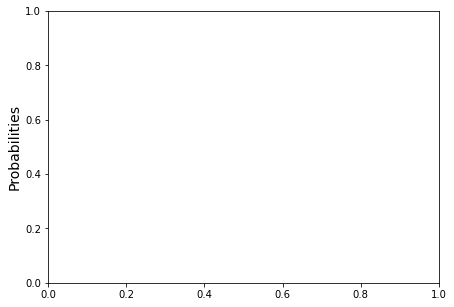

In [32]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
plot_histogram(counts)

##### Hmmmmm that's not a good sign, the code copied directly from Qiskit threw an error^^ about duplicate key of 'stavector' and I don't really know how to fix that

### Teleportation on a real quantum computer

In [33]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [34]:
qc = QuantumCircuit(3, 1)

#initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

#start teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

#send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()

#Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

#undo the initialization
qc.append(inverse_init_gate, [2])

#measure and draw circuit
qc.measure(2, 0)

qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░───────■────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │                    
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░───■───┼────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ ┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░─┤ X ├─■─┤ disentangler ├┤M├
              ░      └───┘ ░            ░ └───┘   └──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0

#### Now to the real device

In [35]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

In [36]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [37]:
backend = least_busy(provider.backends(
    filters=lambda b: b.configuration().n_qubits >= 3 and
    not b.configuration().simulator and b.status().operational==True))

t_qc = transpile(qc, backend, optimization_level=3)

job = backend.run(t_qc)

job_monitor(job)

Job Status: job has successfully run


{'0': 837, '1': 187}


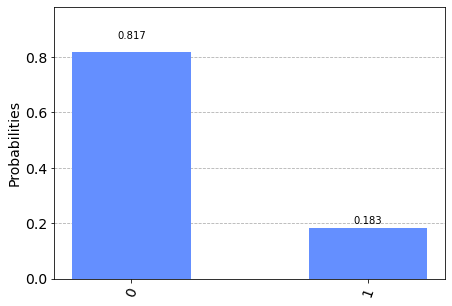

In [38]:
#get results and display them

exp_result = job.result()
exp_counts = exp_result.get_counts(qc)

print(exp_counts)

plot_histogram(exp_counts)

In [47]:
error_rate = exp_counts['1'] / (exp_counts['0'] + exp_counts['1'])

print(f"Error rate: {np.round(error_rate * 100,1)}%")

Error rate: 18.3%
